# Câu 1: Tính sự tương quan giữa A và B

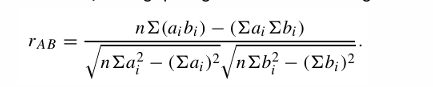

In [ ]:
import sqlite3
import math

# Tạo database
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Tạo bảng
cursor.execute("""
CREATE TABLE Scores (
    A REAL,
    B REAL
)
""")

data = [
    (8, 9),
    (7.5, 8.5),
    (6, 7),
    (7, 6)
]
cursor.executemany("INSERT INTO Scores (A, B) VALUES (?, ?)", data)

# Truy vấn SQL 
cursor.execute("""
SELECT 
    COUNT(*) as n,
    SUM(A) as sum_a,
    SUM(B) as sum_b,
    SUM(A * B) as sum_ab,
    SUM(A * A) as sum_a2,
    SUM(B * B) as sum_b2
FROM Scores
""")

# Lấy kết quả
n, sum_a, sum_b, sum_ab, sum_a2, sum_b2 = cursor.fetchone()

# Áp dụng công thức
numerator = n * sum_ab - sum_a * sum_b
denominator = math.sqrt(n * sum_a2 - sum_a**2) * math.sqrt(n * sum_b2 - sum_b**2)
r_ab = numerator / denominator

print("Hệ số tương quan Pearson r_AB =", r_ab)


Hệ số tương quan Pearson r_AB = 0.6910506641398757


# Câu 2: Một công ty oto đang kiểm tra 3 loại mẫu mới A, B và C trong 4 ngày, và chấm điểm theo thang từ 1 đến 10 điểm cho mỗi ngày với bảng sau. Liệu có sự khác biệt đáng kể giữa các mẫu dựa trên điểm số mà chúng nhận được trong 4 ngày thử nghiệm không? Kết quả thử nghiệm phụ thuộc vào ngày hay phụ thuộc vào mẫu xe? Hãy chuyển đổi dữ liệu sang dạng quan hệ và thực hiện kiểm tra χ2

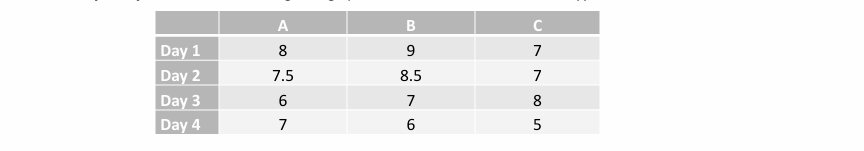

In [ ]:
import sqlite3
import pandas as pd
from scipy.stats import chi2_contingency

# Tạo database SQLite
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Tạo bảng điểm
cursor.execute("""
CREATE TABLE Scores (
    day TEXT,
    sample TEXT,
    score INTEGER
)
""")

data = [
    ("Day 1", "A", 8), ("Day 1", "B", 9), ("Day 1", "C", 7),
    ("Day 2", "A", 7.5), ("Day 2", "B", 8.5), ("Day 2", "C", 7),
    ("Day 3", "A", 6), ("Day 3", "B", 7), ("Day 3", "C", 8),
    ("Day 4", "A", 7), ("Day 4", "B", 6), ("Day 4", "C", 5)
]
cursor.executemany("INSERT INTO Scores (day, sample, score) VALUES (?, ?, ?)", data)

# Chuyển về dạng bảng (day x sample)
df = pd.read_sql_query("""
SELECT day, 
       MAX(CASE WHEN sample = 'A' THEN score END) AS A,
       MAX(CASE WHEN sample = 'B' THEN score END) AS B,
       MAX(CASE WHEN sample = 'C' THEN score END) AS C
FROM Scores
GROUP BY day
""", conn)

print("Bảng dữ liệu:")
df.head()

Bảng dữ liệu:


,day,A,B,C
0,Day 1,8.0,9.0,7
1,Day 2,7.5,8.5,7
2,Day 3,6.0,7.0,8
3,Day 4,7.0,6.0,5


**Sử dụng phương pháp kiểm định Chi-Square(X2 test) đêr xem mối quan hệ giữa mấu và điểm số**

In [6]:
# Kiểm định chi-square
chi2, p, dof, expected = chi2_contingency(df[['A', 'B', 'C']].values)

print("Chi-square:", chi2)
print("p-value:", p)
print("Kết luận:", "Có sự khác biệt đáng kể" if p < 0.05 else "Không có sự khác biệt đáng kể")

Chi-square: 0.826439691310499
p-value: 0.9913459315666546
Kết luận: Không có sự khác biệt đáng kể


# Câu 3: Bảng flights(departure_time,…) chứa các giá trị thời gian dưới dạng số nguyên (ví dụ: 830 cho 8:30 AM, 1445 cho 2:45 PM). Hãy chuyển đổi các giá trị này thành định dạng thời gian.

In [15]:
import sqlite3

# Tạo database SQLite
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Tạo bảng dữ liệu flight_schedule
cursor.execute("""
CREATE TABLE flight_schedule (
    flight_id INTEGER PRIMARY KEY,
    time_code INTEGER
)
""")

# Dữ liệu đầu vào
flight_data = [
    (1, 830),
    (2, 1445),
    (3, 1230),
    (4, 700),
    (5, 2200)
]

# Thêm dữ liệu vào bảng
cursor.executemany("INSERT INTO flight_schedule VALUES (?, ?)", flight_data)

# Truy vấn và chuyển đổi định dạng thời gian
query = """
SELECT 
    flight_id,
    time_code,
    printf('%02d:%02d %s',
           CASE 
               WHEN time_code / 100 % 12 = 0 THEN 12
               ELSE time_code / 100 % 12
           END,
           time_code % 100,
           CASE 
               WHEN time_code / 100 >= 12 THEN 'PM'
               ELSE 'AM'
           END
    ) AS readable_time
FROM flight_schedule
"""

cursor.execute(query)

# In kết quả
print(f"{'ID':<5} {'Code':<6} {'Formatted Time'}")

for row in cursor.fetchall():
    print(f"{row[0]:<5} {row[1]:<6} {row[2]}")


ID    Code   Formatted Time
1     830    08:30 AM
2     1445   02:45 PM
3     1230   12:30 PM
4     700    07:00 AM
5     2200   10:00 PM


#  Câu 4: Viết truy vấn SQL để tìm các ngoại lệ bằng cách sử dụng MAD. Một quy tắc chung là xem xét các giá trị ngoại lệ lớn hơn 1,5 lần so với giá trị MAD, trong đó x là số độ lệch chuẩn mà ta coi là có ý nghĩa.

In [18]:
import sqlite3
import statistics

# Kết nối SQLite
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Tạo bảng dữ liệu "sensor_data"
cursor.execute("""
CREATE TABLE sensor_data (
    id INTEGER PRIMARY KEY,
    value REAL
)
""")

# Chèn dữ liệu mẫu
data = [
    (1, 10.5),
    (2, 11.0),
    (3, 10.8),
    (4, 12.2),
    (5, 50.0),  # outlier
    (6, 11.3),
    (7, 10.7),
    (8, 9.8),
    (9, 11.1)
]
cursor.executemany("INSERT INTO sensor_data(id, value) VALUES (?, ?)", data)
conn.commit()


In [20]:
# Lấy toàn bộ dữ liệu value để tính MAD trong Python
cursor.execute("SELECT value FROM sensor_data")
values = [row[0] for row in cursor.fetchall()]

# Tính median và MAD
median_val = statistics.median(values)
mad = statistics.median([abs(x - median_val) for x in values])

# Định nghĩa ngưỡng ngoại lệ (giá trị lệch quá 1.5 lần MAD)
threshold = 1.5 * mad

# Truy vấn các giá trị ngoại lệ
query = f"""
SELECT id, value
FROM sensor_data
WHERE ABS(value - {median_val}) > {threshold}
"""

cursor.execute(query)

# In kết quả
print("Giá trị ngoại lệ (outliers):")
print(f"{'ID':<5} {'Value':<10}")
for row in cursor.fetchall():
    print(f"{row[0]:<5} {row[1]:<10.2f}")


Giá trị ngoại lệ (outliers):
ID    Value     
1     10.50     
4     12.20     
5     50.00     
8     9.80      


# Câu 5: Hãy xác định liệu hai người trong bảng Patient(last_name, weight, height) có phải là một người hay không bằng cách sử dụng khoảng cách kết hợp Boolean trên “last_name” và “weight”

In [21]:
# Tạo bảng Patient
cursor.execute("""
CREATE TABLE Patient (
    last_name TEXT,
    weight REAL,
    height REAL
)
""")
# Thêm một vài dòng ví dụ
patients = [
    ("Nguyen", 65, 170),
    ("Le", 0, 180),          # nghi ngờ không phải người
    ("Truong", 999, 160),    # nghi ngờ không phải người
    ("null", 70, 175)
]
cursor.executemany("INSERT INTO Patient VALUES (?, ?, ?)", patients)

# Truy vấn: Nếu last_name IS NULL hoặc weight = 0 hoặc quá cao => nghi ngờ không phải người
df_pat = pd.read_sql_query("""
SELECT *,
       CASE 
         WHEN last_name IS NULL OR weight <= 0 OR weight > 300 
         THEN 'Không phải người'
         ELSE 'Người'
       END AS classification
FROM Patient
""", conn)

print(df_pat)


  last_name  weight  height    classification
0    Nguyen    65.0   170.0             Người
1        Le     0.0   180.0  Không phải người
2    Truong   999.0   160.0  Không phải người
3      null    70.0   175.0             Người
